## Things to implement: 

- Chi squared offline feature selection [here](https://docs.google.com/presentation/d/1kdqs7pAWWmFbHszl2N6Km-2X7nujMcMH5bu_g9ZGNWQ/edit#slide=id.g190c813b98_3_511)
- Online feature selection [here](https://docs.google.com/presentation/d/1kdqs7pAWWmFbHszl2N6Km-2X7nujMcMH5bu_g9ZGNWQ/edit#slide=id.g190c813b98_3_511)
- NN
- SVM 
- BDT

# Milestone P4: Team KLR - Extending the comparison of classification models for rare civil war onsets

This notebook serves as an extension of Comparing Random Forest with Logistic Regression for Predicting Class-Imbalanced Civil War Onset Data by Muchlinski David, Siroky David, He Jingrui & Kocher Matthew (2016). In similar fashion as Muchlinski et al., 2016, we aim to contribute to the insofar discarded predictive statistical methods in political science, in favor of accurately predicting significant events such as civil wars. To this end, Muchlinski et al., 2016's approach of comparing experimental performance of algorithmic maneuveurs via a multitude of metrics is adopted. However, in contrast with only using Random Forest and near-arbitrarily selecting features, we attempt in our paper to explore and implement additional feature-selection and classification methods through rigorous incorporation of boosting, and a variety of classification algorithms, as well as on and offline feature selection, which benefit an extended, deepened comparison and discussion surrounding not only this imbalanced prediction task, but also the causal estimation of features. While indeed from Muchlinski et al., 2016, it seems that Random Forests drastically outperform their determined competitor in all metrics employed, nuance of their strengths and weaknesses in contrast with more suited models remains uninvestigated, providing justification for extending this analysis.

First, we implement on-and-offline feature selection methods building on Muchlisnki' et al's comparison of Fearon and Latin (2003), Collier and Hoeffler (2004), and Hegre and Sambanis (2006). From which we would like to uncover how feature selection methods serve to aid model performance. The .txt file `notes.txt` contains which variables were used originally by Fearon and Latin (2003), Collier and Hoeffler (2004), and Hegre and Sambanis (2006). We first retrieve these and later compare performance with and without arbitrary feature selection. 

In [1]:
!cat './data/notes.txt'

The main dataset you have to use is `SambnisImp.csv`.
Additionally, the provided `Sambanis Codebook.pdf` file contains a textual
description of (most) used variables.

---

When loading the data for replication purposes, note that the authors only
load the following 91 variables:

    "warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4"

In [19]:
# import necessary libraries, define data path, and other hard-coded variables
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper

DATA_PATH = './data/'
seed = 7

# Extract features used in each paper from notes.txt 
with open(DATA_PATH+'notes.txt') as f:
    
    task_notes = f.readlines()
    task_notes = ''.join(task_notes)
    
    fl_feature_names = re.search(r'(?<=Fearon and Laitin \(2003\):)[^.\.]*',task_notes).group()
    fl_feature_names = re.sub('\n|\s|\"','',fl_feature_names).split(',')
    
    ch_feature_names = re.search(r'(?<=Collier and Hoeffler \(2004\):)[^.\.]*',task_notes).group()
    ch_feature_names = re.sub('\n|\s|\"','',ch_feature_names).split(',')

    hs_feature_names = re.search(r'(?<=Hegre and Sambanis \(2006\):)[^.\.]*',task_notes).group()
    hs_feature_names = re.sub('\n|\s|\"','',hs_feature_names).split(',')
    
    auth_features = re.search(r'(?<=91 variables:)[^.\(]*',task_notes).group()
    auth_features = re.sub('\n|\s|\"','',auth_features).split(',')
    
# load data
master_data = pd.read_csv(DATA_PATH+'SambnisImp.csv', index_col='X')

# split data into features used for each paper and retrieve regressand 
y_master = master_data['warstds']

fl_x = master_data[fl_feature_names]
ch_x = master_data[ch_feature_names]
hs_x = master_data[hs_feature_names]
auth_x = master_data[auth_features]

In [22]:
def compute_roc_vals(X, y, pipeline):
    
    # set seed and ensure input are numpy arrays
    np.random.seed(seed)
    X, y = X.to_numpy(), y.to_numpy()
    
    # If logistic regression, compute best regularization weight and set it
    if 'logisticregression' in pipeline.named_steps:
    
        n_grid_search = 5
        r_lambda = LogisticRegressionCV(Cs = n_grid_search, cv=10, max_iter=10000, scoring='roc_auc', random_state = seed).fit(X, y)
        pipeline['logisticregression'].set_params(C = r_lambda.C_[0], random_state = seed)
        
        # Predict the probabilities with a cross validation
        y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict_proba')[:,1]
        
        
    if 'randomforestclassifier' or 'balancedrandomforestclassifier' in pipeline.named_steps:
        
        y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict_proba')[:,1]
    
    if 'svc' in pipeline.named_steps:
        
        pass
        #y_pred = cross_val_predict(pipeline, X, y, cv=10, method='predict')
    
    # Compute the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y, y_pred)
    # Compute the area under the fpr-tpr curve
    auc_score = auc(fpr, tpr)
    # Compute f1 score
    f1 = f1_score(y, (y_pred > 0.5).astype(int)) # how do they get figure 3? i get f1 scores of 0 because the model doesnt predict any civil war onsets..
    
    return fpr, tpr, auc_score, f1

# rewrite this function with seaborn
def roc_plt(fpr, tpr, auc_score):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Area = {:.2f}".format(round(auc_score,2)))
    plt.show()
    
roc_vals={}

First we reproduce the plots from the authors as follows, (can remove later if unnecessary/undesired) - I also dont know how they get f1 scores from these logistic models, given that the f1 score is 0 for multiple of them..

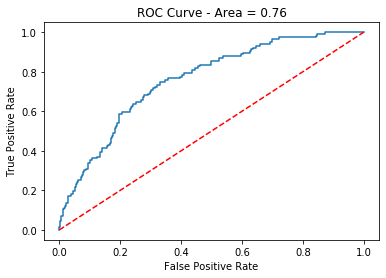

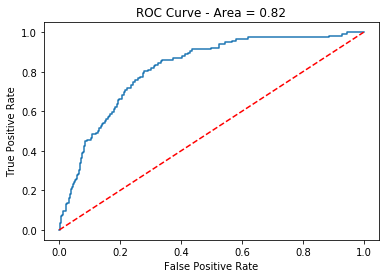

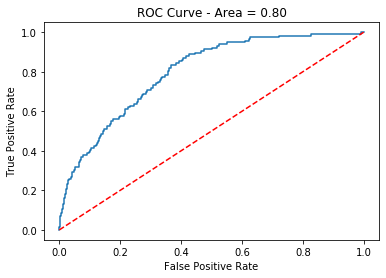

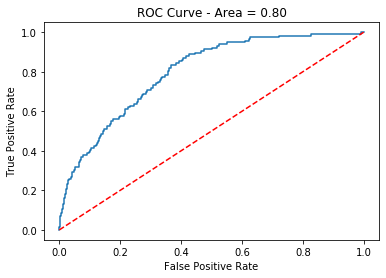

In [29]:
# roc plots for logistic models
log_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, penalty='l2'))

roc_vals['log_fl'] = compute_roc_vals(fl_x, y_master, log_pipeline)
roc_vals['log_ch'] = compute_roc_vals(ch_x, y_master, log_pipeline)
roc_vals['log_hs'] = compute_roc_vals(hs_x, y_master, log_pipeline)
roc_vals['log_auth'] = compute_roc_vals(hs_x, y_master, log_pipeline)
roc_plt(*roc_vals['log_fl'][:3])
roc_plt(*roc_vals['log_ch'][:3])
roc_plt(*roc_vals['log_hs'][:3])
roc_plt(*roc_vals['log_auth'][:3])

Interestingly, it seems that the noise from the inclusion of all the variables does not allow the Logistic Model to increase AUC score. The noise is poorly dealt with by the logistic model. Does the RF suffer from the same problem?

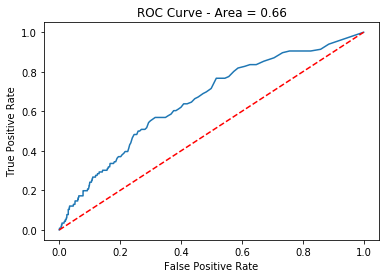

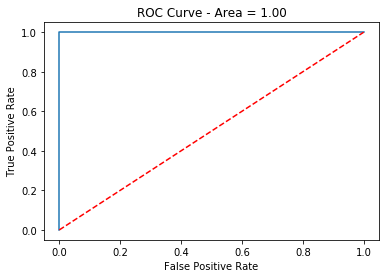

In [30]:
n_trees = 1000
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_trees))
# roc plots for rf without downsampling - fearon laitin variables
roc_vals['rf_fl'] = compute_roc_vals(fl_x, y_master, rf_pipeline)
# roc plots for rf without downsampling - all 90 variables the authors load
roc_vals['rf_auth'] = compute_roc_vals(auth_x, y_master, rf_pipeline)
roc_plt(*roc_vals['rf_fl'][:3])
roc_plt(*roc_vals['rf_auth'][:3])

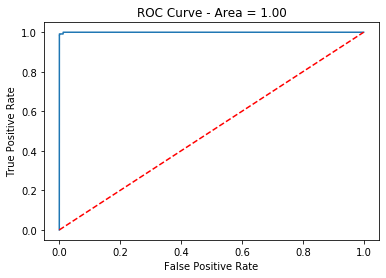

In [26]:
# roc plots for rf with downsampling - all 90 variables the authors load
down_sample_ratio = 1/2
brf_pipeline = make_pipeline(StandardScaler(), BalancedRandomForestClassifier(n_estimators=1000, sampling_strategy = down_sample_ratio))
roc_vals['brf'] = compute_roc_vals(auth_x, y_master, brf_pipeline)
roc_plt(*roc_vals['brf'][:3])

It seems, in fact, that the dataset is simple enough for an AUC score of 1 with barely any hyperparameter optimization, begging the question of which variables the authors' used and how they concluded with a marginally lower AUC score of 0.90. However, this is a first illustration of the ability of the RF to deal with class imbalanced data and steadily deal with the noise unlike the logistic models. Therefore, pinning the importance of feature selection in more simplistic models which cannot filter through the noise. We move on to more suited models (Support vector machines (if this one doesnt work well we can move on to another model), Boosted Decision Trees, and Neural Networks). 

## SVM 

https://stats.stackexchange.com/questions/37795/roc-curve-for-discrete-classifiers-like-svm-why-do-we-still-call-it-a-curve

In [75]:
from sklearn import svm

svm_pipeline = make_pipeline(StandardScaler(), svm.SVC())